## Classification of Speech Frames

### PART IV:  RECOGNIZE A PHONEME FROM FILTERBANK FEATURES WITH A DNN

### 1. Setting up your Python Environment

1. Import Python's Machine Learning Stack

2. Import needed local utilities that are needed for this exercise

  a. Auxiliary functions: data loading/saving + feature extraction + phone label mapping

  b. Pytorch functions: NN architecture + training + evaluation 

  c. Define setups: predefined setups (feature extraction, labels, training data)


In [ ]:
#@title Import libraries

% matplotlib inline
import sys,os,io
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import scipy.io as sio
import urllib.request

# imports from pytorch
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# reproducibility 
torch.manual_seed(0) 
np.random.seed(0)

# imports from the scikit-learn 
from sklearn.datasets.base import Bunch
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import Perceptron
from sklearn import metrics as skmetrics
from sklearn.mixture import GaussianMixture
from scipy.fftpack import dct

try:
  import google.colab
  IN_COLAB = True
  ! pip install git+https://github.com/compi1234/pyspch.git
except:
  IN_COLAB = False

from pyspch.GaussianMixtureClf import GaussianMixtureClf
import pyspch.display as spchd

  Cloning https://github.com/compi1234/pyspch.git to /tmp/pip-req-build-6tufevjx
  Running command git clone -q https://github.com/compi1234/pyspch.git /tmp/pip-req-build-6tufevjx


In [ ]:
#@title Auxiliary functions 

## Pickle functions 
import pickle
import gzip

# save pickled file
def pickle_data(df, filename):   
    file_object = gzip.open(filename, "wb")
    print("Generating " + filename, end=" ...")
    pickle.dump(df, file_object)
    print("done")
    file_object.close()

# open pickled file
def unpickle_data(filename):
    file_object = open(filename, "rb")
    df = pickle.load(file_object)
    file_object.close()
    return df


## Download functions

import requests

# download from url and write to file
def write_from_url(url, filename):
    r = requests.get(url)
    with open(filename, 'wb') as f:
        f.write(r.content)

## Phoneme segmentation  

# phone segmentation to phone per frame in utterance
def phnseg_to_phns(phnseg, nframes):
    phn_list = []
    for seg_idx, seg in phnseg.iterrows():
        seg_nframes = seg['t1'] - seg['t0']
        phn_list += [seg['seg']] * seg_nframes
        
    return phn_list    
 
# phone segmentation to center frame of phone per frame
def phnseg_to_center_frames(phnseg, nframes):
    center_frame_ids = []
    for seg_idx, seg in phnseg.iterrows():
        seg_nframes = seg['t1'] - seg['t0']
        center_frame_ids += [int(seg['t0'] + seg_nframes / 2)] * seg_nframes
        
    return center_frame_ids

##  Window

# The window is determined by utterance boundaries (frame_idx, utt_nframes) 
# and the window parameters (window_nframes, stride). The window is represented 
# by indices relative to the frame index.

# window indices relative to frame index
def get_window(frame_idx, utt_nframes, window_nframes, stride, shift=0):
    
    def window_bounds(window_nframes):
        if window_nframes % 2 == 0:    
            # even case: start-i-center-i-i-end (example window_nframes=6)       
            start = -window_nframes / 2 + 1
            end = window_nframes / 2
        else:                       
            # uneven case: start-i-ref-i-stop (example window_nframes=5)       
            start = -(window_nframes - 1) / 2
            end = (window_nframes - 1) / 2  
            
        return start, end
    
    def adjust_window_to_utt_bounds(window):
        new_window = []
        for rel_idx in window:
            rel_idx = max(rel_idx, 0 - frame_idx)
            rel_idx = min(rel_idx, utt_nframes - 1 - frame_idx)
            new_window.append(rel_idx)
            
        return np.array(new_window)
    
    # window boundaries w.r.t. center frame
    start, end = window_bounds(window_nframes)
    # window of evenly spaced frames around center frame
    window = np.arange(start, end + 1).astype(int) 
    # apply stride and shift
    window = window * stride + shift 
    # adjust window indices out of the utterance bounds
    window = adjust_window_to_utt_bounds(window)
    
    return window

# window indices for each frame in utterance
def get_windows_for_utt(utt_nframes, window_nframes, stride, shift):
    utt_windows = []
    # iterate over frames in utterance
    for frame_idx in range(utt_nframes):
        window = get_window(frame_idx, utt_nframes,
                            window_nframes, stride, shift)
        utt_windows.append(window)
    
    return utt_windows

# apply window to frames  
def apply_window(frames, frame_ids, frame_windows):
    inputs = []
    # ensure type is numpy for easy indexing
    frames = np.array(frames)
    # iterate over frames 
    for frame_idx, frame_window in zip(frame_ids, frame_windows):
        # apply window
        feature = np.stack(frames[frame_window + int(frame_idx)], axis=0)
        # save feature
        inputs.append(feature)
        
    return np.stack(inputs, axis=0)

## Reshape

# reshape features assuming first dimension is 'examples'
def reshape_features(frames, shape=(-1,)):
    # n_examples = len(frames)
    # new_shape = (n_examples, *shape)
    
    return [np.reshape(frame, shape) for frame in frames]

## Normalization and derrivatives

# normalization
def normalize_data(data, axis=0, normMean=False, normVar=True):
    if normMean:
        mean = data.std(axis=axis) 
        data = np.subtract(data, mean)
    if normVar:
        stdev = data.std(axis=axis) 
        data = np.divide(data, stdev)
    
    return data

# temporal derrivatives
def add_derrivatives_data(data, delta=True, ddelta=True):   
    if delta:
        data_delta = np.gradient(data, axis=0)
        data = np.concatenate((data, data_delta), axis=-1)
    if ddelta:
        data_delta = np.gradient(data, axis=0)
        data_ddelta = np.gradient(data_delta, axis=0)
        data = np.concatenate((data, data_delta, data_ddelta), axis=-1)
 
    return data


## Wrapper for assembling dataframe containing frames 

# assemble dataframe
#   = row per frame
# - path                    = utterance identifier
# - center frame index      = index of center frame for current phoneme
# - frame index             = index of frame for current phoneme
# - window indices          = window indices 
def assemble_frame_dataframe(df, window_nframes=5, stride=2, shift=0,
                             delta=True, ddelta=False,
                             normMean=False, normVar=True):
    frame_dfs = []
    # iterate over utterances
    for _, utt in df.iterrows():
        
        ## modify feature vector
        # utterance data
        data = utt['data']
        # add temporal derrivatives
        data = add_derrivatives_data(data, delta=delta, ddelta=ddelta)
        # normalize standard deviation per channel (feature dimension)
        data = normalize_data(data, axis=0, normMean=normMean, normVar=normVar)
        
        ## labels and names
        # number of frames in utterance
        utt_nframes = data.shape[0]
        # utterance name for each frame
        utt_names = [utt['utt_name']] * utt_nframes
        # phone segmentation to phone per frame in utterance
        phnseg = utt['phn_seg']
        utt_phns = phnseg_to_phns(phnseg, utt_nframes)
        centre_frame_ids = phnseg_to_center_frames(phnseg, utt_nframes)
        # - indices of (feature) window per frame in utterance 
        utt_windows = get_windows_for_utt(utt_nframes, window_nframes=window_nframes, 
                                          stride=stride, shift=shift)
        
        # index of last frame
        # - correct for occasional mismatch in number of frames and phone labels
        eidx = min(utt_nframes, len(utt_phns))
        
        ## frame dataframe per utterance  
        # - row per frame in utterance
        # - columns: "utt_name", "frame_idx", window", "data", "phn_label"
        frame_df = pd.DataFrame({'utt_name' : utt_names[:eidx],
                               'center_frame_idx' : centre_frame_ids[:eidx],
                               'frame_idx' : np.arange(utt_nframes)[:eidx],
                               'window' :  utt_windows[:eidx],
                               'data' : list(data[:eidx]),
                               'org_phn_label' : utt_phns[:eidx]})
         
        frame_dfs.append(frame_df)
    
    # concatenate frame dataframes per utterance to final frame dataframe 
    frame_df = pd.concat(frame_dfs, ignore_index=True)
    
    return frame_df


## Phone and label mapping 

# TIMIT phone label to phone label (using phone_map_file)
def get_phn2phn_map(phone_map_file, ocol, icol=0):
    phn2phn = {}
    with open(phone_map_file) as file:
        for line in file:
            w = line.strip().split("\t")
            phn2phn[w[icol]] = w[ocol]
            
    return phn2phn 

# phone label to numeric label
def get_phn2lab_map(phn_labels):
    phn_labels = unique_list(phn_labels)
    phn2lab_map = {phn : i for i, phn in enumerate(phn_labels) }
    lab2phn_map = {i : phn for i, phn in enumerate(phn_labels) }
    
    return phn2lab_map, lab2phn_map 

# numeric label (based on 'icol') to other numeric label (based on '0col')
def get_lab2lab_dict(phone_map_file, icol, ocol, phn_set=None):
    # phn2phn
    iphn2ophn = get_phn2phn_map(phone_map_file, ocol, icol)

    # phn2lab x2
    iphn2lab, _ = get_phn2lab_map(list(iphn2ophn.keys()))
    ophn2lab, _ = get_phn2lab_map(list(iphn2ophn.values())) 

    # lab2lab
    ilab2olab = {iphn2lab[k]:ophn2lab[v] for k,v in iphn2ophn.items()}
    
    return ilab2olab

# get unique items in list
def unique_list(lst): 
    # dict perserves order (vs. set)
    return list(dict.fromkeys(lst))


## Operations on dataframe  {display-mode: "form"}

# split 'utt_name' column for easy data selection
def split_string_column(df, col_dict, sep="/"):  
    for key, value in col_dict['target'].items():
        df[key] = df.apply(lambda row: row[col_dict['source']].split(sep)[value], axis=1)
    
    return df 

# data selection based on regex in columns
def filter_regex_dataframe(df, include, exclude=None):
    if include is not None:
        for key, value in include.items():
            if value is not None:
                df = df[df[key].str.contains(value)]
                
    if exclude is not None:
        for key, value in exclude.items():
            if value is not None:
                df = df[~df[key].str.contains(value)]
    
    return df

### Wrapper functions

def phone_and_label_mapping(phone_map_file, ocol=1, phn_set=None):

    # phone mapping parameters
    # ocol -> {0 : TIMIT 61 phone label, 1 : 48 phone label, 2: 39 phone label}

    # phone mapping - phn2phn dictionairy = {TIMIT phone label : phone label}
    phn2phn = get_phn2phn_map(phone_map_file, ocol=ocol)

    # label mapping - phn2lab dictionairy = {phone label : integer label}
    if phn_set == None:
        phn_set = unique_list([phn for phn in phn2phn.values()]) # all values
    
    phn2lab, lab2phn = get_phn2lab_map(phn_set)

    return phn2phn, phn2lab, lab2phn, phn_set

# split in train / validation / test set 
def utterance_based_data_split(frames_df): 

    # add columns for easy splitting
    col_dict = {'source' : 'utt_name',
                'target' : {'dataset' : 0, 'dialect' : 1, 
                            'speaker' : 2, 'utterance' : 3}}
    frames_df = split_string_column(frames_df, col_dict=col_dict, sep='/')

    # define split
    train_re_incl = {'dataset' : 'train'}
    train_re_excl = {'dialect' : 'dr8', 'utterance' : 'sa'}
    valid_re_incl = {'dataset' : 'train', 'dialect' : 'dr8'}
    valid_re_excl = {'utterance' : 'sa'}
    test_re_incl = {'dataset' : 'test'}
    test_re_excl = {'utterance' : 'sa'}

    # split
    train_df = filter_regex_dataframe(frames_df, train_re_incl, train_re_excl)
    valid_df = filter_regex_dataframe(frames_df, valid_re_incl, valid_re_excl)
    test_df = filter_regex_dataframe(frames_df, test_re_incl, test_re_excl)

    return train_df, valid_df, test_df



In [ ]:
#@title Pytorch functions

## Neural network architecture

# simple fully-connected feedforward neural network 
class Dnn(nn.Module):
    
    def __init__(self, in_dim, out_dim, hidden_layer_sizes):
        super(Dnn, self).__init__()

        # attributes
        self.in_dim = in_dim
        self.out_dim = out_dim
        self.hidden_layer_sizes = hidden_layer_sizes

        # parameters
        layer_sizes = (in_dim, *hidden_layer_sizes, out_dim)
        layer_sizes_pairwise = [(layer_sizes[i], layer_sizes[i+1]) for 
                                 i in range(len(layer_sizes)-1)]

        # define architecture
        modulelist = nn.ModuleList([])  
        for i, (layer_in_size, layer_out_size) in enumerate(layer_sizes_pairwise):
            modulelist.append(nn.Linear(layer_in_size, layer_out_size))
            if i < len(self.hidden_layer_sizes):
                modulelist.append(nn.Sigmoid())

        # define network as nn.Sequential
        self.net = nn.Sequential(*modulelist)

    def forward(self, x):
        x = self.net(x)
        return x

class View(nn.Module):
    def __init__(self, shape):
        super().__init__()
        self.shape = shape

    def forward(self, input):
        batch_size = input.size(0)
        shape = (batch_size, *self.shape)
        out = input.view(shape)
        return out


# fully-connected neural network with 1D convolutional layer
class Cnn1d(nn.Module):
    
    def __init__(self, in_dim, out_dim, hidden_layer_sizes,
                 kernel_size=(5, ), padding=(2, ), n_filters=100,
                 cnn_position=0):
        super(Cnn1d, self).__init__()

        # attributes
        self.in_dim = in_dim
        self.out_dim = out_dim
        self.hidden_layer_sizes = hidden_layer_sizes

        # parameters
        layer_sizes = (in_dim, *hidden_layer_sizes, out_dim)
        layer_sizes_pairwise = [(layer_sizes[i], layer_sizes[i+1]) for 
                                 i in range(len(layer_sizes)-1)]

        # define architecture
        modulelist = nn.ModuleList([])
        for i, (layer_in_size, layer_out_size) in enumerate(layer_sizes_pairwise):

            if i == cnn_position:
                modulelist.append(nn.Conv1d(layer_in_size, n_filters, 
                                            kernel_size, padding=padding))
                modulelist.append(View(shape=(-1, )))
                    
            else:
                modulelist.append(nn.Linear(layer_in_size, layer_out_size))

            if i < len(self.hidden_layer_sizes):
                modulelist.append(nn.Sigmoid())

        # define network as nn.Sequential
        self.net = nn.Sequential(*modulelist)

    def forward(self, x):
        x = self.net(x)
        return x

def init_weights(m, bias=0.00):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(bias)


# fully-connected neural network with 1D convolutional layer
class Cnn2d(nn.Module):
    
    def __init__(self, in_dim, out_dim, hidden_layer_sizes,
                 kernel_size=(5, 5), padding=(2, 2), n_filters=25,
                 cnn_position=0):
        super(Cnn2d, self).__init__()

        # attributes
        self.in_dim = in_dim
        self.out_dim = out_dim
        self.hidden_layer_sizes = hidden_layer_sizes

        # parameters
        layer_sizes = (in_dim, *hidden_layer_sizes, out_dim)
        layer_sizes_pairwise = [(layer_sizes[i], layer_sizes[i+1]) for 
                                 i in range(len(layer_sizes)-1)]

        # define architecture
        modulelist = nn.ModuleList([])
        for i, (layer_in_size, layer_out_size) in enumerate(layer_sizes_pairwise):

            if i == cnn_position:
                modulelist.append(nn.Conv2d(layer_in_size, n_filters, 
                                            kernel_size, padding=padding))
                modulelist.append(View(shape=(-1, )))
                    
            else:
                modulelist.append(nn.Linear(layer_in_size, layer_out_size))

            if i < len(self.hidden_layer_sizes):
                modulelist.append(nn.Sigmoid())

        # define network as nn.Sequential
        self.net = nn.Sequential(*modulelist)

    def forward(self, x):
        x = self.net(x)
        return x


# =============================================================================
# Neural network training
# =============================================================================

# simple batch gradient descent 
def train_batch(network, train_X, train_y, criterion, optimizer, device, 
                n_epochs=500, every=10):

    # data-format is torch tensor + send to device (ex. GPU)
    if not torch.is_tensor(train_X):
        train_X = torch.tensor(train_X, dtype=torch.float32).to(device)
    if not torch.is_tensor(train_y):
        train_y = torch.tensor(train_y, dtype=torch.long).to(device)

    # send network to device (ex. GPU)
    network.to(device)

    # set network to training mode (vs. evaluation mode)
    network.train() 

    # save training loss
    train_loss = []

    # train for some epochs - full batch
    for epoch in range(n_epochs):
        optimizer.zero_grad()
        output = network(train_X)
        loss = criterion(output, train_y)
        loss.backward()
        optimizer.step()
        if epoch%every == 0:
          print('Epoch {}, loss {}'.format(epoch, loss.item()))
        
        train_loss.append(loss.item())
      
    return train_loss
            
# mini-batch gradient descent with early stopping
def train(network, train_dl, criterion, optimizer, device, n_epochs=500, 
          valid_X=None, valid_y=None, patience=5, every=10, 
          current_epoch=0):

    # set early stopping counter
    cnt_valid_loss_increase = 0

    # current_epoch
    last_epoch = current_epoch

    # data-format is torch tensor + send to device (ex. GPU)
    if not torch.is_tensor(valid_X):
        valid_X = torch.tensor(valid_X, dtype=torch.float32).to(device)
    if not torch.is_tensor(valid_y):
        valid_y = torch.tensor(valid_y, dtype=torch.long).to(device)

    # save training and validation loss
    train_loss_list = []
    valid_loss_list = []

    #  per epoch: update network parameters 
    for epoch in range(n_epochs):

        # network to training mode
        network.train()
        
        # early stopping 
        earlystoppping = cnt_valid_loss_increase > patience
        if earlystoppping:
            print("stopped early after %d epochs" % (epoch))
            return train_loss_list, valid_loss_list, last_epoch

        # per mini-batch: compute gradient (backpropagation) + take step 
        running_loss = 0
        steps = 0 
        for i, data in enumerate(train_dl, 0):

            # mini-batch inputs and labels
            frames, labels = data  
            
            # zero the parameter gradients
            optimizer.zero_grad()
            
            # forward + backward + optimize 
            outputs = network.net(frames)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()  

            # running loss
            running_loss += loss.item()

        # training loss
        mean_minibatch_loss = running_loss/len(train_dl)
        train_loss_list.append(mean_minibatch_loss)
        if epoch%every == 0:   
            print("Epoch %d -- av. loss per mini-batch %.2f" % (epoch, mean_minibatch_loss))

        # validation loss
        if valid_X is not None and valid_y is not None: 
            # network to evaluation mode
            network.eval()

            with torch.no_grad():
                valid_outputs = network.net(valid_X)
                valid_loss = criterion(valid_outputs, valid_y)
                valid_loss_list.append(valid_loss.item())
                
                # early stoppping
                loss_increase = valid_loss_list[-1] > min(valid_loss_list[-patience:])
                if loss_increase:
                    # no improvement compared to last 'patience' steps
                    cnt_valid_loss_increase += 1
                else:
                    cnt_valid_loss_increase = 0

        last_epoch = current_epoch + epoch + 1

    return train_loss_list, valid_loss_list, last_epoch


# =============================================================================
# Neural network saving and loading 
# =============================================================================

# save model
def save_model(epoch, model, criterion, optimizer, model_file):
    torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'criterion': criterion,
            'optimizer_state_dict': optimizer.state_dict(),
            }, model_file)
    
    doPrint = False
    if doPrint:
        print('Saved model to: ' + model_file)

# load model
def load_model(model, optimizer, model_file, device, strict=False):
    doPrint = False
    if doPrint:
        print('Loading: ' + model_file)
        
    checkpoint = torch.load(model_file, map_location=device)
    epoch = checkpoint['epoch']    
    model.load_state_dict(checkpoint['model_state_dict'], strict=strict)
    criterion = checkpoint['criterion']
    if doPrint:
        print(checkpoint['optimizer_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    
    return epoch, model, criterion, optimizer


## Neural network evaluation

# evaluate criterion
def evaluate_criterion(network, test_X, test_y, criterion, device):
    
    # data-format is torch tensor + send to device (ex. GPU)
    if not torch.is_tensor(test_X):
        test_X = torch.tensor(test_X, dtype=torch.float32).to(device)
    if not torch.is_tensor(test_y):
        test_y = torch.tensor(test_y, dtype=torch.long).to(device)

    # send network to device (ex. GPU)
    network.to(device)

    # set network to evaluation mode (vs. training mode)
    network.eval() 

    # compute loss based on criterion
    pred_y = network.net(test_X)
    loss = criterion(pred_y, test_y)

    return loss.item()

# evaluate confusion matrix
def confusionmatrix(network, test_X, test_y, device, 
                    n_per_pass=2**10, unsqueeze=False, unsqueeze2d=False):
    
    # data-format is torch tensor + send to device (ex. GPU)
    if not torch.is_tensor(test_X):
        test_X = torch.tensor(test_X, dtype=torch.float32).to(device)
    if not torch.is_tensor(test_y):
        test_y = torch.tensor(test_y, dtype=torch.long).to(device)

    # send network to device (ex. GPU)
    network.to(device)

    # set network to evaluation mode (vs. training mode)
    network.eval() 

    # compute confusion matrix
    cm = np.zeros((network.out_dim, network.out_dim))
        
    # splitting up dataframe in managable chunks
    n_samples = len(test_X)
    loop_n_times = math.ceil(n_samples/n_per_pass)
    for i in range(loop_n_times):
      test_X_part = test_X[i*n_per_pass:(i+1)*n_per_pass]
      test_y_part = test_y[i*n_per_pass:(i+1)*n_per_pass]
      for input, label in zip(test_X_part, test_y_part):
        if unsqueeze: prob = network.net(torch.unsqueeze(input, 0))
        elif unsqueeze2d: prob = network.net(torch.reshape(input, (1, *input.shape)))
        else: prob = network.net(input) # output = posterior class probabilities
        pred = torch.argmax(prob) # prediction = label (or neuron) with highest probability (One-Hot Encoding)
        cm[label][pred] += 1
    
    return cm.astype(int)


# remap confusion matrix
def remap_confusionmatrix(confusionmatrix, lab2lab_dict):
    
    n_classes = confusionmatrix.shape[0]
    n_classes_new = len(np.unique((np.fromiter(lab2lab_dict.values(), dtype=int))))
    confusionmatrix_new = np.zeros((n_classes_new, n_classes_new))
    
    # remap classes
    for row in range(n_classes):
        for col in range(n_classes):
            confusionmatrix_new[lab2lab_dict[row], lab2lab_dict[col]] += confusionmatrix[row,col]
            
    return confusionmatrix_new

# evaluate phone error rate
def evaluate_PER(confusionmatrix):

    n_classes = confusionmatrix.shape[0]    
    
    # compute ER 
    trace = np.trace(confusionmatrix)
    ER = 1- trace.sum() / confusionmatrix.sum()
        
    # compute ER per class (disregarding non label or not)
    no_examples_pc = confusionmatrix.sum(axis=1)
    ER_pc = [None] * n_classes
    for i in range(n_classes):
        if no_examples_pc[i] != 0:
            ER_pc[i] = 1-confusionmatrix[i,i] / (no_examples_pc[i])
        
    return ER, ER_pc


## Confusion matrix plot

import matplotlib.pyplot as plt
import seaborn as sns

# pretty printing
def plot_confusion_matrix(cm, labels=[], cmap=[], figsize=(6,6), fontsize=14):

    if len(labels) == 0:
        df_cm = pd.DataFrame(cm)
    else:
        df_cm = pd.DataFrame(cm, labels, labels)
        
    f, ax = plt.subplots(figsize=figsize)
    sns.set(font_scale=1.4)#for label size
    sns.heatmap(df_cm, annot=True, fmt="d", annot_kws={"fontsize": fontsize,"color":'k'},
                square=True, linecolor='k', linewidth=1.5, cmap=cmap, cbar=False)
    ax.tick_params(axis='y', labelrotation=0.0, left=True)
    # font size
    plt.title('Confusion matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()


## Dataset 

class SimpleDataset(Dataset):
    """Simple dataset for easy sampling."""

    def __init__(self, data_X, data_y, labels, labeldict, device):

        # dimensionality
        self.n_samples, self.n_features = data_X.shape[0:2]
        self.n_classes = len(labels)

        # input data
        self.frames = data_X # (n_samples, n_features)
        self.frames = torch.as_tensor(self.frames, dtype=torch.float32).to(device)

        # labels
        if data_y.dtype != "int64":
            data_y = np.vectorize(labeldict.get)(data_y)
        self.labels = torch.as_tensor(data_y, dtype=torch.long).to(device)

    def __len__(self):
        
        return self.n_samples

    def __getitem__(self, idx):
        frame = self.frames[idx] 
        label = self.labels[idx]
        
        return frame, label


In [ ]:
#@title Define setups

def prepare_baseline(utt_df, utt_names=None, phone_map_file='phones-61-48-39.txt'):
    
    ## DATA SELECTION -- utterance based (speed up)
    if utt_names is not None:
        utt_df = utt_df[utt_df['utt_name'].isin(utt_names)]

    ## FEATURE EXTRACTION

    # input feature parameters
    window_nframes = 11
    stride = 2
    shift = 0
    delta, ddelta = False, False
    normMean, normVar = False, True

    # generate dataframe containing frames
    frames_df = assemble_frame_dataframe(utt_df, window_nframes, stride, shift, \
                                        delta, ddelta, normMean, normVar)

    # assemble input feature from window
    features = apply_window(frames_df['data'], frames_df.index, frames_df['window'])
    #frames_df['feature'] = features
    frames_df['feature'] = reshape_features(features, (-1,)) 

    ## LABELS

    # phone and label mapping
    ocol = 1 # {'61' : 0, '48' : 1, '39' : 2}
    phn_set = None
    phn2phn, phn2lab, lab2phn, phn_set = phone_and_label_mapping(phone_map_file, ocol, phn_set)

    # map phones and labels
    frames_df['phn_label'] = frames_df['org_phn_label'].map(phn2phn) # TIMIT phone label -> phone label
    frames_df['int_label'] = frames_df['phn_label'].map(phn2lab)  # phone label ->  integer label

    ## DATA SELECTION -- frame based

    # drop phones not in phn_set
    frames_df = frames_df[~frames_df['int_label'].isna()] 

    # drop phones with large shift in phn_set
    doShift = False
    max_shift = 5 # shift = distance to center frame
    if doShift:  
      frames_df['shift'] = frames_df['frame_idx'] - frames_df['center_frame_idx']
      frames_df = frames_df[frames_df['shift'].abs() < max_shift ]

    return frames_df

def prepare_shortvowels(utt_df, utt_names=None, phone_map_file='phones-61-48-39.txt',
                        phn_set=['aa', 'ae', 'ah', 'ao', 'eh', 'ih', 'ix', 'uh']):
    
    ## DATA SELECTION -- utterance based (speed up)
    if utt_names is not None:
        utt_df = utt_df[utt_df['utt_name'].isin(utt_names)]

    ## FEATURE EXTRACTION

    # input feature parameters
    window_nframes = 11
    stride = 2
    shift = 0
    delta, ddelta = False, False
    normMean, normVar = False, True

    # generate dataframe containing frames
    frames_df = assemble_frame_dataframe(utt_df, window_nframes, stride, shift, \
                                        delta, ddelta, normMean, normVar)

    # assemble input feature from window
    features = apply_window(frames_df['data'], frames_df.index, frames_df['window'])
    frames_df['feature'] = reshape_features(features, (-1,)) 

    ## LABELS

    # phone and label mapping
    ocol = 1 # {'61' : 0, '48' : 1, '39' : 2}
    #phn_set =  ['aa', 'ih']#['aa', 'ae', 'ah', 'ao', 'eh', 'ih', 'ix', 'uh'] 
    phn2phn, phn2lab, lab2phn, phn_set = phone_and_label_mapping(phone_map_file, ocol, phn_set)

    # map phones and labels
    frames_df['phn_label'] = frames_df['org_phn_label'].map(phn2phn) # TIMIT phone label -> phone label
    frames_df['int_label'] = frames_df['phn_label'].map(phn2lab)  # phone label ->  integer label

    ## DATA SELECTION -- frame based

    # drop phones not in phn_set
    frames_df = frames_df[~frames_df['int_label'].isna()] 

    # drop phones with large shift in phn_set
    doShift = False
    max_shift = 5 # shift = distance to center frame
    if doShift:  
      frames_df['shift'] = frames_df['frame_idx'] - frames_df['center_frame_idx']
      frames_df = frames_df[frames_df['shift'].abs() < max_shift ]

    return frames_df

def prepare_cnn(utt_df, utt_names=None, phone_map_file='phones-61-48-39.txt'):
    
    ## DATA SELECTION -- utterance based (speed up)
    if utt_names is not None:
        utt_df = utt_df[utt_df['utt_name'].isin(utt_names)]

    ## FEATURE EXTRACTION

    # input feature parameters
    window_nframes = 11
    stride = 2
    shift = 0
    delta, ddelta = False, False
    normMean, normVar = False, True

    # generate dataframe containing frames
    frames_df = assemble_frame_dataframe(utt_df, window_nframes, stride, shift, \
                                        delta, ddelta, normMean, normVar)

    # assemble input feature from window
    features = apply_window(frames_df['data'], frames_df.index, frames_df['window'])
    frames_df['feature'] = reshape_features(features, (-1,)) 

    ## LABELS

    # phone and label mapping
    ocol = 1 # {'61' : 0, '48' : 1, '39' : 2}
    phn_set = None
    phn2phn, phn2lab, lab2phn, phn_set = phone_and_label_mapping(phone_map_file, ocol, phn_set)

    # map phones and labels
    frames_df['phn_label'] = frames_df['org_phn_label'].map(phn2phn) # TIMIT phone label -> phone label
    frames_df['int_label'] = frames_df['phn_label'].map(phn2lab)  # phone label ->  integer label

    ## DATA SELECTION -- frame based

    # drop phones not in phn_set
    frames_df = frames_df[~frames_df['int_label'].isna()] 

    # drop phones with large shift in phn_set
    doShift = False
    max_shift = 5 # shift = distance to center frame
    if doShift:  
      frames_df['shift'] = frames_df['frame_idx'] - frames_df['center_frame_idx']
      frames_df = frames_df[frames_df['shift'].abs() < max_shift ]


## Custom setups

f11s2_setup = {'window_nframes' : 11, 'stride' : 2, 'shift' : 0,
               'delta' : False, 'ddelta' : False,
               'normMean' : False, 'normVar' : True}

f7s2_setup = {'window_nframes' : 7, 'stride' : 2, 'shift' : 0,
               'delta' : False, 'ddelta' : False,
               'normMean' : False, 'normVar' : True}

f7s2d_setup = {'window_nframes' : 7, 'stride' : 1, 'shift' : 0,
               'delta' : True, 'ddelta' : False,
               'normMean' : False, 'normVar' : True}

f13s1_setup = {'window_nframes' : 13, 'stride' : 1, 'shift' : 0,
               'delta' : False, 'ddelta' : False,
               'normMean' : False, 'normVar' : True}

f13s2_setup = {'window_nframes' : 13, 'stride' : 2, 'shift' : 0,
               'delta' : False, 'ddelta' : False,
               'normMean' : False, 'normVar' : True}


def prepare_setup(utt_df, setup, utt_names=None, ocol=1, phn_set=None,  
                  phone_map_file='phones-61-48-39.txt'):
    
    ## DATA SELECTION -- utterance based (speed up)
    if utt_names is not None:
        utt_df = utt_df[utt_df['utt_name'].isin(utt_names)]

    ## FEATURE EXTRACTION

    # input feature parameters
    window_nframes = setup['window_nframes']
    stride = setup['stride']
    shift = setup['shift']
    delta, ddelta = setup['delta'], setup['ddelta']
    normMean, normVar = setup['normMean'], setup['normVar']

    # generate dataframe containing frames
    frames_df = assemble_frame_dataframe(utt_df, window_nframes, stride, shift, \
                                        delta, ddelta, normMean, normVar)

    # assemble input feature from window
    features = apply_window(frames_df['data'], frames_df.index, frames_df['window'])
    frames_df['feature'] = reshape_features(features, (-1,)) 

    ## LABELS

    # phone and label mapping
    phn2phn, phn2lab, lab2phn, phn_set = phone_and_label_mapping(phone_map_file, ocol, phn_set)

    # map phones and labels
    frames_df['phn_label'] = frames_df['org_phn_label'].map(phn2phn) # TIMIT phone label -> phone label
    frames_df['int_label'] = frames_df['phn_label'].map(phn2lab)  # phone label ->  integer label

    ## DATA SELECTION -- frame based

    # drop phones not in phn_set
    frames_df = frames_df[~frames_df['int_label'].isna()] 

    # drop phones with large shift in phn_set
    doShift = False
    max_shift = 5 # shift = distance to center frame
    if doShift:  
      frames_df['shift'] = frames_df['frame_idx'] - frames_df['center_frame_idx']
      frames_df = frames_df[frames_df['shift'].abs() < max_shift ]

    return frames_df

### 2. The Database 
The experiments in this notebook use the TIMIT database.
Instead of starting from raw speech, we already extracted features (24 filterbank energies) from the speech signal. The feature is obtained by applying the FFT transform (**window step** = 10ms, window size = 30ms, window = Hamming, ...) and mel scaling to the speech waveform (16kHz). Note the window step determines the frame duration (10ms).

The dataframe contains for each utterance:
- utt_name : utterance name
- data : matrix of # frames in utterance x 24 mel-scaled filterbank energies 
- phn_seg : segmentation of utterance into phones

The phone mapping is used translate the original 61 phone labels used by TIMIT to a smaller phone set with 48 (or 39) phone labels.

**Questions**

Q1. What is the effect of reducing the number of phone labels from 61 to 48?

In [ ]:
# Download dataframe 
root_url = 'http://homes.esat.kuleuven.be/~spchlab/data/timit/'
utt_df_url = root_url + 'examples/timit-fb24-100Hz-text.pkl' 
utt_df = pd.read_pickle(utt_df_url) 

# Download phone mapping
phone_map_file = 'phones-61-48-39.txt'
phone_map_file_url = root_url + 'examples/phones-61-48-39.txt'
write_from_url(phone_map_file_url, phone_map_file)

test/dr1/faks0/si2203
The reasons for this dive seemed foolish now.



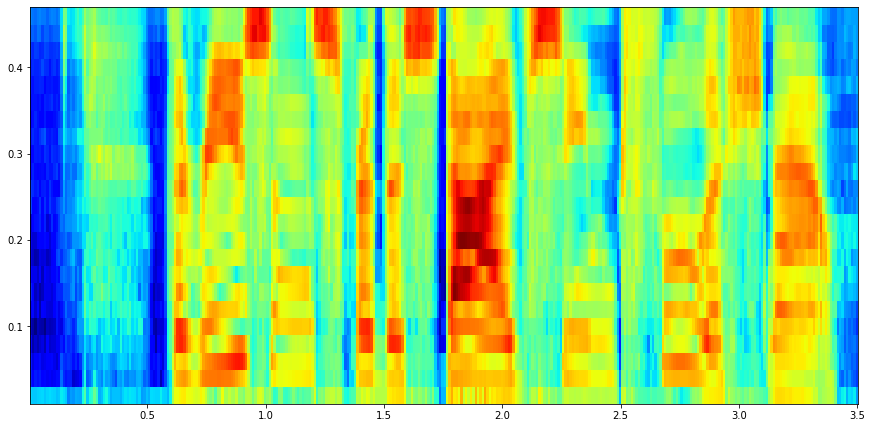

    t0   t1 seg
1   60   62  dh
2   62   67  ix
3   67   75   r
4   75   92  iy
5   92  102   z
6  102  105  ax
7  105  120   n
8  120  132   z


In [ ]:
# Visualize 24 filterbank energies for an utterance
loc = 1
print(utt_df['utt_name'].iloc[loc])
print(utt_df['text'].iloc[loc][8:])
f = spchd.PlotSpg(spgdata=utt_df['data'].iloc[loc].T, segspg=utt_df['phn_seg'].iloc[loc])
display(f) # OPM: phone boundaries missing

# phone segmentation
print(utt_df['phn_seg'].iloc[loc][1:9])

#### Set phone label mapping

In [ ]:
# Preprocessing (short vowel dataset)

# phn_set can be None (all phones) or a subset of the phones 
long_vowels = ['aw', 'ay', 'er', 'ey', 'iy', 'ow', 'oy', 'uw']
short_vowels = ['aa', 'ao', 'ae', 'ah', 'ax', 'eh', 'ih', 'ix', 'uh']
phn_set = None # short_vowels # long_vowels

# compute phone and label mapping
ocol = 1 # {0 :'61 phones' : 0, 1 : '48 phones', 2 : '39 phones'}
phn2phn, phn2lab, lab2phn, phn_set = phone_and_label_mapping(phone_map_file, ocol, phn_set)

### DNN baseline model on 48 phones
We will use a simple neural network to classify the frames. In Pytorch, the network is constructed as a sequence of modules (the basic building blocks). Here we use a fully connected feed-forward network, with a sigmoid activation function following each hidden layer. The network is then defined by the input, output and hidden layer sizes. 

The input feature is a window of 11 frames (black) around the target frame (red). Notice we use a stride of 2, giving window that spans 210 ms. 

The phone labels are one-hot encoded, we thus have a neuron for each phone label in the output layer of the network. By applying the softmax function at the end of the network, we obtain phone probabilities as outputs. The predicted label is then the one with the highest probabilty. 

<img src="http://homes.esat.kuleuven.be/~spchlab/data/timit/dnn_setup_3.PNG" width="750">

#### DNN architecture

First we define a neural network architecture, then we load in weights from a pretrained model with the TIMIT training data. 


In [ ]:
# set device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 

In [ ]:
# feature dimension
feature_dim = 24
window_nframes = 11

# define neural network
in_dim = window_nframes * feature_dim # OPM: adapt to symbols
out_dim = len(phn_set)
hidden_layer_sizes = [1024, 768, 512]
dnn_model = Dnn(in_dim, out_dim, hidden_layer_sizes)
dnn_model.to(device)
print(dnn_model)

# training parameters
batch_size = 128
shuffle = True
lrn_rate = 0.001
weight_decay = 0

# initialize optimizer
optimizer = torch.optim.Adam(dnn_model.parameters(), lr=lrn_rate, weight_decay=weight_decay) 

Dnn(
  (net): Sequential(
    (0): Linear(in_features=264, out_features=1024, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=1024, out_features=768, bias=True)
    (3): Sigmoid()
    (4): Linear(in_features=768, out_features=512, bias=True)
    (5): Sigmoid()
    (6): Linear(in_features=512, out_features=48, bias=True)
  )
)


In [ ]:
# download model
model_file = 'dnn_baseline_model.pt'
model_url = root_url + 'models/dnn_baseline_model.pt'
write_from_url(model_url, model_file)

# load model
epoch, dnn_model, criterion, optimizer = load_model(dnn_model, optimizer, model_file, device)

#### Prediction for single utterance

The posterior probabilties are now visualized for one entire utterance below. Because the dataset (after feature extraction) is quite big, we avoid loading unnecessary data. Here we only do the feature extraction for a single utterance.

In [ ]:
f11s2_setup = {'window_nframes' : 11, 'stride' : 2, 'shift' : 0,
               'delta' : False, 'ddelta' : False,
               'normMean' : False, 'normVar' : True} # OPM: stride

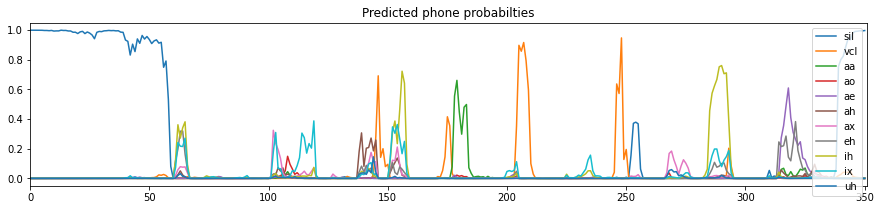

In [ ]:
# baseline feature extraction for single example utterance 
example_name = 'test/dr1/faks0/si2203'
example_df = prepare_setup(utt_df, f11s2_setup, [example_name])
example_X = np.vstack(example_df['feature']).astype('float32') # example_df['feature']
example_X = torch.Tensor(example_X).to(device)

# output for single example utterance 
example_yp = dnn_model(example_X) # log probs
example_yp = torch.nn.Softmax(dim=1)(example_yp) # probs

# plot input
if False:
  utt_fig, utt_ax = plt.subplots(figsize=(15, 10))
  utt_ax.matshow(example_X.cpu().detach().numpy().T)
  print(utt_df[utt_df['utt_name']==example_name]['text'].iloc[0])

# plot output - posterior probabilities
plot_df = pd.DataFrame(example_yp.cpu().detach().numpy())
plot_df.columns = [lab2phn[col] for col in plot_df.columns]
cols = plot_df.columns # choose phones to plot
cols = ['sil', 'vcl'] + short_vowels # + long_vowels # 
plot_df[cols].plot(title="Predicted phone probabilties", figsize=(15, 3), xlim=[0, len(example_df)])


#### Prediction for complete test set

Now we evaluate the pretrained model on the whole TIMIT test set. First we compute the confusion matrix and then, using the confusion matrix, the phone error rate (PER) (= 1 - accuracy) and the PER per phone label. Notice that working with the whole dataset is slower.

##### Prepare test data

In [ ]:
# Prepare setup
# ! takes around 1 minute (~ combining frames in context window)

# data split
utt_train_df, utt_val_df, utt_test_df = utterance_based_data_split(utt_df)

# test set feature extraction (all test sentences = takes about a minute)
test_df = prepare_setup(utt_test_df, f11s2_setup)

# test set 
test_X = np.vstack(test_df['feature']).astype('float32') 
test_y = test_df['int_label'].to_numpy().astype('int64')

##### Evaluate model on test data

In [ ]:
# Evaluation
# ! takes around 2 minutes (~ predicting phone probabilities for each example)

# confusionmatrix and phone error rate (another minute or two)
cm = confusionmatrix(dnn_model, test_X, test_y, device)
print(evaluate_PER(cm))

# 48 phone set to 39 phone set mapping (rescore)
lab2lab = get_lab2lab_dict(phone_map_file, 1, 2)
cm39 = remap_confusionmatrix(cm, lab2lab)
print(evaluate_PER(cm39))

(0.322396295918813, [0.4974761637689288, 0.3652340019102197, 0.6227652733118971, 0.4392826274848747, 0.5990402559317516, 0.6332703213610587, 0.2792776247321702, 0.2883826879271071, 0.47567221510883484, 0.36208829712683954, 0.3850267379679144, 0.6107843137254902, 0.5280865124662061, 0.37957400327689783, 0.4775854416333777, 0.523523839595832, 0.3707247333113384, 0.6826165960024227, 0.5546525802519301, 0.5089734386216798, 0.2916784468947319, 0.24139030612244894, 0.5570672713529856, 0.052646317558107, 0.35934237995824636, 0.5430711610486891, 0.47777096428023913, 0.21827198852772467, 0.43580181140117213, 0.28455024764339354, 0.2058518230180355, 0.36502694246480094, 0.2883266335619138, 0.4837765619035501, 0.6238286479250335, 0.346336822074215, 0.40549796371714175, 0.14569429926831234, 0.2083109439369515, 0.3079796772265392, 0.7183348095659876, 0.859214501510574, 0.43013846430498115, 0.4826200047292504, 0.33510729613733903, 0.5760151085930123, 0.3865238229489709, 0.7468553459119497])
(0.28622

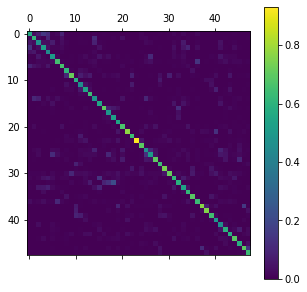

In [ ]:
# plot normalized confusion matrix
plotCm = True
if plotCm:
    from sklearn.preprocessing import normalize
    fig, ax = plt.subplots(figsize=(5, 5))
    cm_image = ax.matshow(normalize(cm, axis=0, norm='l1'), interpolation='nearest')
    fig.colorbar(cm_image, ax=ax)

plotCmDetail = False
if plotCmDetail:
    # detail plot confusion matrix
    plot_confusion_matrix(cm, phn_set, figsize=(20,20), fontsize=10)

### DNN vs. GMM on short vowels

Last exercise session on phoneme classification, we compared the performance of DNNs and GMMs. Near the end we remarked the toy problem was too small for meaningful conclusions. Here we compare the two models on a subset of TIMIT data, namely for the short vowels. 

In [ ]:
# free up disk space
#del baseline_df 
#del utt_test_df
#del test_df 

In [ ]:
# subset of phone labels
long_vowels = ['aw', 'ay', 'er', 'ey', 'iy', 'ow', 'oy', 'uw']
short_vowels = ['aa', 'ao', 'ae', 'ah', 'ax', 'eh', 'ih', 'ix', 'uh']

# use a subset of phones
phn_set = short_vowels # short_vowels # long_vowels # None # 

# compute phone and label mapping
ocol = 1 # {0 :'61 phones' : 0, 1 : '48 phones', 2 : '39 phones'}
phn2phn, phn2lab, lab2phn, phn_set = phone_and_label_mapping(phone_map_file, ocol, phn_set)

#### Prepare train/validation/test data

In [ ]:
# feature extraction for all utterances 
shortvowels_df = prepare_setup(utt_df, f11s2_setup, phn_set=phn_set)

# phone and label mapping
phn2phn, phn2lab, lab2phn, phn_set = phone_and_label_mapping(phone_map_file, ocol, phn_set)

# split data
train_df, valid_df, test_df = utterance_based_data_split(shortvowels_df)

# labels
train_y = train_df['int_label'].to_numpy().astype('int64') 
valid_y = valid_df['int_label'].to_numpy().astype('int64')
test_y = test_df['int_label'].to_numpy().astype('int64')

#### DNN model

In [ ]:
# DNN features
dnn_train_X = np.vstack(train_df['feature']).astype('float32') 
dnn_valid_X = np.vstack(valid_df['feature']).astype('float32') 
dnn_test_X = np.vstack(test_df['feature']).astype('float32') 

In [ ]:
## DNN model - identical to baseline (except for output layer)

# define neural network
in_dim = 11 * 24
out_dim = len(phn_set)
hidden_layer_sizes = [1024, 768, 512]

dnn_model = Dnn(in_dim, out_dim, hidden_layer_sizes)
dnn_model.to(device)

# training parameters
n_epochs = 500
patience = 15
lrn_rate = 0.00001
weight_decay = 0

criterion = nn.CrossEntropyLoss() # applies softmax()
dnn_optimizer = torch.optim.Adam(dnn_model.parameters(), lr=lrn_rate, weight_decay=weight_decay)

# dataset 
dnn_train_ds = SimpleDataset(dnn_train_X, train_y, phn_set, phn2lab, device)

# dataloader
batch_size = 128
shuffle = True
dnn_train_dl = DataLoader(dnn_train_ds, batch_size=batch_size, shuffle=shuffle, num_workers=0)

# training
dnn_results = train(dnn_model, dnn_train_dl, criterion, dnn_optimizer, device, 
                    n_epochs, dnn_valid_X, valid_y, patience, every=10)
dnn_train_loss, dnn_valid_loss, dnn_epoch = dnn_results

Epoch 0 -- av. loss per mini-batch 2.00
Epoch 10 -- av. loss per mini-batch 1.34


KeyboardInterrupt: ignored

In [ ]:
# plot training and validation loss
plt.figure()
plt.plot(dnn_train_loss)
plt.plot(dnn_valid_loss)
plt.title("Training and validation loss - fully connected input layer")
plt.legend(['train', 'validation'])

In [ ]:
# compute confusionmatrix 
dnn_cm = confusionmatrix(dnn_model, dnn_test_X, test_y, device)

# phone error rate
print(evaluate_PER(dnn_cm))

In [ ]:
# plot normalized confusion matrix
plotCm = True
if plotCm:
    from sklearn.preprocessing import normalize
    fig, ax = plt.subplots(figsize=(5, 5))
    cm_image = ax.matshow(normalize(dnn_cm, axis=0, norm='l1'), interpolation='nearest')
    fig.colorbar(cm_image, ax=ax)
    ax.set_xticklabels(['']+list(phn2lab.keys()))  
    ax.set_yticklabels(['']+list(phn2lab.keys()))

In [ ]:
# save model
!mkdir -p 'models/'
dnn_model_file = 'models/dnn_shortvowel_model.pt'
dnn_model_dict = {'epoch': dnn_epoch,
                  'model_state_dict': dnn_model.state_dict(),
                  'criterion': criterion,
                  'optimizer_state_dict': dnn_optimizer.state_dict()}
torch.save(dnn_model_dict, dnn_model_file)

#### GMM model

In [ ]:
#@title GMM functions

# =============================================================================
# GMM
# =============================================================================

def train_test_GMM(X_train,X_test,y_train,y_test,classes,
                     n_components=1,max_iter=20,tol=1.e-3,print_result=True,print_cmat=False):
    clf_GM = GaussianMixtureClf(classes=classes,n_components=n_components,max_iter=20,tol=1.e-3)
    clf_GM.fit(X_train,y_train)
    y_pred = clf_GM.predict(X_train)
    acc_train = 100.0*skmetrics.accuracy_score(y_train, y_pred)
    y_pred = clf_GM.predict(X_test)
    acc_test = 100.0*skmetrics.accuracy_score(y_test, y_pred) 
    cmat = skmetrics.confusion_matrix(y_test,y_pred)
    if(print_result):
        lls, bics = llscore(clf_GM,X_train,y_train)
        print('Training Set:  Accuracy = %.2f%%     LL = %.2f    BIC = %.2f ' % (acc_train,lls,bics) )
        print('Test Set:      Accuracy = %.2f%%'  % (acc_test) )
    if(print_cmat):
        plot_confusion_matrix(cmat,labels=classes)
    return (acc_test,acc_train)

def llscore(GMM,X,y):
    ''' Average log likelihood per sample over the full data set (X,y) 
    and BIC per sample '''
    ll = 0.
    for k in range(0,GMM.n_classes) :
        ll += GMM.gmm[k].score(X[y== GMM.classes[k],: ])
    lls = ll.mean()
    nparam = ((2*n_dim+1)*n_components -1 ) * GMM.n_classes
    bics = -2*lls + (np.log(X.shape[0])* nparam) / float(X.shape[0])
    return(lls,bics)


In [ ]:
# GMM features
gmm_train_X = np.vstack(train_df['data']).astype('float32') 
gmm_valid_X = np.vstack(valid_df['data']).astype('float32') 
gmm_test_X = np.vstack(test_df['data']).astype('float32') 

# use MFCC features for GMM
mfcc_train_X = dct(gmm_train_X, type=2, axis=1, norm='ortho')
mfcc_test_X = dct(gmm_test_X, type=2, axis=1, norm='ortho')

# add first order temporal derrivatives for GMM
mfcc_train_X = add_derrivatives_data(mfcc_train_X, delta=True, ddelta=False)
mfcc_test_X = add_derrivatives_data(mfcc_test_X, delta=True, ddelta=False)

In [ ]:
# initialize model
gmm_model = GaussianMixture(n_components=len(phn_set), covariance_type='diag', tol=0.001,
                            reg_covar=1e-06, max_iter=100, n_init=1, 
                            init_params='kmeans', random_state=1, warm_start=False)

# spchlab implementation 
if False:
  gmm = GMM(n_components=len(phn_set), covariance_type='diag', tol=0.001, 
            min_covar=0.001, max_iter=100, n_init=1, init_params='kmeans', random_state=1)

# train model
gmm_model = gmm_model.fit(mfcc_train_X, train_y)

# prediction and accuracy
pred = gmm_model.predict(mfcc_test_X)
count_correct = sum([1 for pr, lab in zip(pred, test_y) if pr==lab])
per = 1 - count_correct/len(test_y)   
print(per)

In [ ]:
# plot normalized confusion matrix
plotCm = True
if plotCm:
    from sklearn.preprocessing import normalize
    fig, ax = plt.subplots(figsize=(5, 5))
    cm_image = ax.matshow(normalize(cm_shortvowels, axis=0, norm='l1'), interpolation='nearest')
    fig.colorbar(cm_image, ax=ax)
    ax.set_xticklabels(['']+list(phn2lab.keys()))  
    ax.set_yticklabels(['']+list(phn2lab.keys()))

### DNN performance for different input features 

In [ ]:
f7s2_setup = {'window_nframes' : 7, 'stride' : 2, 'shift' : 0,
               'delta' : False, 'ddelta' : False,
               'normMean' : False, 'normVar' : True}

f7s2d_setup = {'window_nframes' : 7, 'stride' : 1, 'shift' : 0,
               'delta' : True, 'ddelta' : False,
               'normMean' : False, 'normVar' : True}

f13s1_setup = {'window_nframes' : 13, 'stride' : 1, 'shift' : 0,
               'delta' : False, 'ddelta' : False,
               'normMean' : False, 'normVar' : True}

f13s2_setup = {'window_nframes' : 13, 'stride' : 2, 'shift' : 0,
               'delta' : False, 'ddelta' : False,
               'normMean' : False, 'normVar' : True}

In [ ]:
# download pretrained models
model_files = ['models/dnn_f7s2_model.pt',     # 7 frames, stride 2 (130 ms)
               'models/dnn_f7s2d_model.pt',    # 7 frames, stride 2, delta (130 ms)
               'models/dnn_f13s1_model.pt',    # 13 frames, stride 1 (130 ms)
               'models/dnn_f13s2_model.pt']    # 13 frames, stride 2 (250 ms)

for model_file in model_files:
  model_url = root_url + model_file
  write_from_url(model_url, model_file)

In [ ]:
setups = [f7s2_setup, f7s2d_setup, f13s1_setup, f13s2_setup]

for model_file, setup in zip(model_files, setups): 
  
  # define neural network
  in_dim = 24 * setup['window_nframes'] * (1 + setup['delta'] + setup['ddelta'])
  out_dim = 48
  hidden_layer_sizes = [1024, 768, 512]

  dnn_model = Dnn(in_dim, out_dim, hidden_layer_sizes)
  dnn_model.to(device)

  # optimizer parameters
  lrn_rate = 0.00001
  weight_decay = 0
  optimizer = torch.optim.Adam(dnn_model.parameters(), lr=lrn_rate, weight_decay=weight_decay)
  
  # load model
  epoch, dnn_model, criterion, optimizer = load_model(dnn_model, optimizer, model_file, device)

  # baseline feature extraction for single example utterance 
  example_name = 'test/dr1/faks0/si2203'
  example_df = prepare_setup(utt_df, setup, [example_name])
  example_X = np.vstack(example_df['feature']).astype('float32') # example_df['feature']
  example_X = torch.Tensor(example_X).to(device)

  # output for single example utterance 
  example_yp = dnn_model(example_X) # log probs
  example_yp = torch.nn.Softmax(dim=1)(example_yp) # probs

  # plot input
  if False:
    utt_fig, utt_ax = plt.subplots(figsize=(15, 10))
    utt_ax.matshow(example_X.cpu().detach().numpy().T)
    print(utt_df[utt_df['utt_name']==example_name]['text'].iloc[0])

  # plot output - posterior probabilities
  plot_df = pd.DataFrame(example_yp.cpu().detach().numpy())
  plot_df.columns = [lab2phn[col] for col in plot_df.columns]
  cols = plot_df.columns # choose phones to plot
  cols = ['sil', 'vcl'] + short_vowels # + long_vowels # 
  plot_df[cols].plot(title="Predicted phone probabilties", figsize=(15, 3), xlim=[0, len(example_df)])

## KLAD

### 4. Train a custom DNN

In [ ]:
# Train model 

# training setup
n_epochs = 500
patience = 5
lrn_rate = 0.001
weight_decay = 0
nesterov = False
criterion = nn.CrossEntropyLoss()  # applies softmax()
#optimizer = torch.optim.SGD(model.parameters(), lr=lrn_rate, weight_decay=weight_decay, nesterov=nesterov)
optimizer = torch.optim.Adam(model.parameters(), lr=lrn_rate, weight_decay=weight_decay) # ties model-parameters to optimizer (back-propagation)

# train network
mode = 'mb_es'
every = 5
if mode == 'batch': 
    train_loss = train_batch(model, train_dnn_X, train_y, criterion, optimizer, device, n_epochs, every)

if mode == 'mb': 
    train_loss = train_minibatch(model, train_dl, criterion, optimizer, device, n_epochs, every)

if mode == 'mb_es' : 
    train_loss, valid_loss = train_minibatch_earlystopping(model, train_dl, criterion, optimizer, device, n_epochs,\
                                                           valid_dnn_X, valid_y, patience, every)


### 3. Feature Extraction


Q1. What happens to the input feature on the phone boundaries?

Q2. What happens to the input feature on the utterance boundaries?

Apart from segmenting the utterance in phones and computing the window for each input feature, we can also normalize and add temporal derrivatives to our feature. Here we will normalize the variance per channel (and per utterance) and add a first order temporal derrivative (called delta).  

For each utterance the temporal derrivate is computed and the variance normalized per channel. The phone segmentation is translated to a phone for each frame and finally the window is computed. The code for this 

### 4. Phone and Label Mapping 
The TIMIT phone labels are mapped onto a smaller set of 49 phones. If you want to run small experiments yourself, you can select a subset with only a couple of phonemes (reducing the size of the dataset and the diversity in labels).

We will use a simple feed forward neural network to classify the frames. In pytorch, the network is constructed as a sequence of modules (basic blocks). We have a fully connected network (nn.Linear), with the activation function (Sigmoid) between all layers. The network is then defined by the input-, output- and hidden layer sizes.